In [1]:
pip install qiskit.ignis

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, assemble, transpile, Aer, IBMQ
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
# from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
from qiskit import execute

from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister
from qiskit.visualization import array_to_latex

# Loading your IBM Quantum account(s)

/tmp/ipykernel_1505/83197244.py:14: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
# provider = IBMQ.get_provider(hub='ibm')
real_backend = least_busy(provider.backends(filters=lambda x: not x.configuration().simulator))
# real_backend = provider.get_backend('ibm_lagos')
print("backend used: ", real_backend)

backend used:  ibmq_manila


In [9]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    oracle_qc.name = "oracle " + case
    return oracle_qc
    # oracle_gate = oracle_qc.to_gate()
    # oracle_gate.name = "Oracle" # To show when we display the circuit
    # return oracle_gate

In [10]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    # dj_circuit.barrier()
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    # dj_circuit.barrier()
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [11]:
aer_sim = Aer.get_backend('aer_simulator')

In [12]:
n = 4

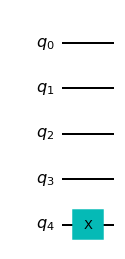

In [14]:
oracle_qc = dj_oracle('constant', n)
oracle_qc.draw()

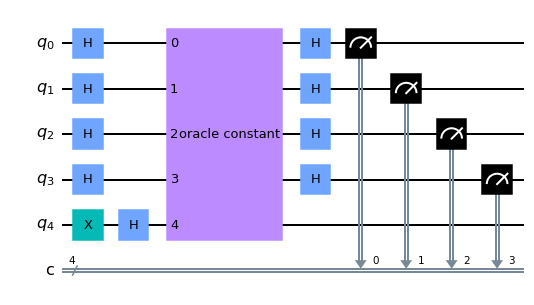

In [15]:
dj_circuit = dj_algorithm(oracle_qc, n)
dj_circuit.draw()

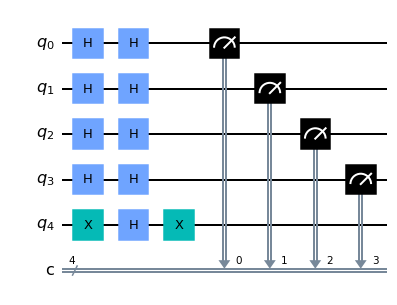

In [16]:
new_dj = dj_circuit.decompose('oracle constant')
new_dj.draw()

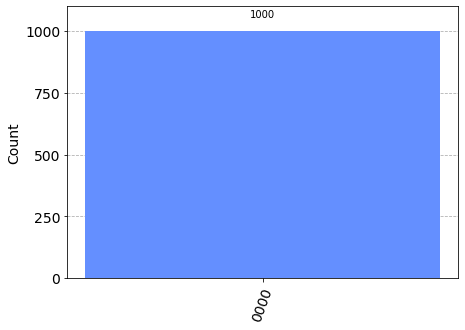

In [17]:
aer_job = execute(dj_circuit, aer_sim, shots=1000)
aer_results = aer_job.result()
aer_counts = aer_results.get_counts()
plot_histogram(aer_counts)

In [18]:
job = execute(dj_circuit, real_backend, shots=1000)
realqc_results = job.result()

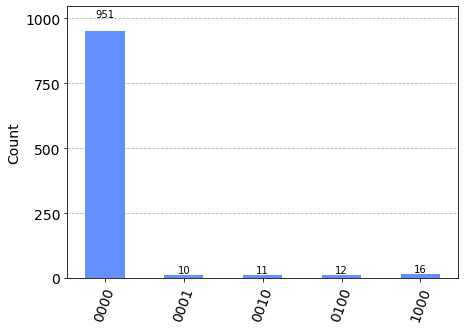

In [19]:
counts = realqc_results.get_counts()
plot_histogram(counts)

In [20]:
# QEM
qr = QuantumRegister(n)
qem_meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
qem_cal_results = real_backend.run(qem_meas_calibs, shots=10000).result()

In [21]:
qem_meas_fitter = CompleteMeasFitter(qem_cal_results, state_labels, circlabel='mcal')
array_to_latex(qem_meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [22]:
# cal_results = aer_sim.run(qem_meas_calibs, shots=10000).result()
# meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
# array_to_latex(meas_fitter.cal_matrix)

In [23]:
# Get the filter object
qem_meas_filter = qem_meas_fitter.filter

# Results with mitigation
mitigated_results = qem_meas_filter.apply(realqc_results)
mitigated_counts = mitigated_results.get_counts()

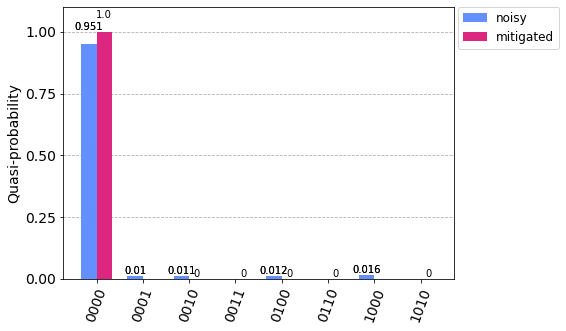

In [24]:
noisy_counts = realqc_results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [25]:
# GEM
# not calibrating ancilla
dj_left0 = QuantumCircuit(n,n)
dj_left1 = QuantumCircuit(n) 
dj_left2 = QuantumCircuit(n)
dj_left3 = QuantumCircuit(n)
dj_left4 = QuantumCircuit(n)
dj_left5 = QuantumCircuit(n)
dj_left6 = QuantumCircuit(n)
dj_left7 = QuantumCircuit(n)
dj_left8 = QuantumCircuit(n)
dj_left9 = QuantumCircuit(n)
dj_left10 = QuantumCircuit(n)
dj_left11 = QuantumCircuit(n)
dj_left12 = QuantumCircuit(n)
dj_left13 = QuantumCircuit(n)
dj_left14 = QuantumCircuit(n)
dj_left15 = QuantumCircuit(n)

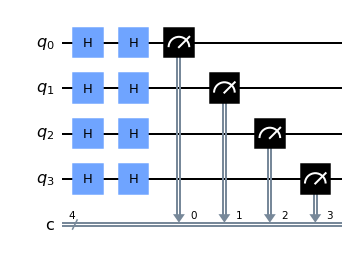

In [26]:
dj_left0.h(0)

dj_left0.h(0)

dj_left0.h(1)
dj_left0.h(1)
dj_left0.h(2)
dj_left0.h(2)
dj_left0.h(3)
dj_left0.h(3)
dj_left0.measure([0,1,2,3], [0,1,2,3])
dj_left0.draw()

/tmp/ipykernel_1505/4218642948.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left1 += dj_left0


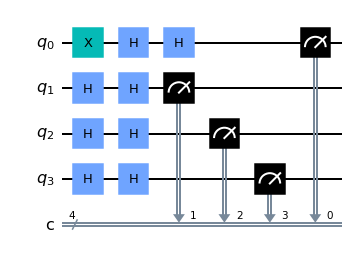

In [27]:
dj_left1.x(0)
dj_left1 += dj_left0
dj_left1.draw()

/tmp/ipykernel_1505/2252380090.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left2 += dj_left0


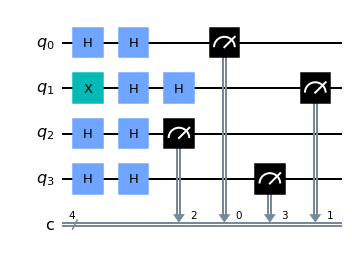

In [28]:
dj_left2.x(1)
dj_left2 += dj_left0
dj_left2.draw()

/tmp/ipykernel_1505/810308772.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left3 += dj_left0


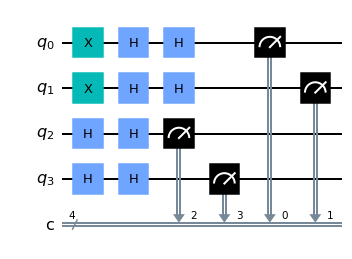

In [29]:
dj_left3.x(0)
dj_left3.x(1)
dj_left3 += dj_left0
dj_left3.draw()

/tmp/ipykernel_1505/264572622.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left4 += dj_left0


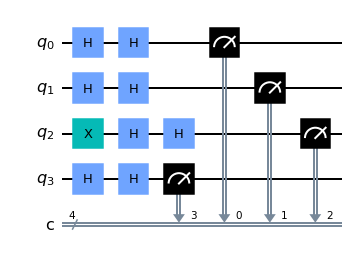

In [30]:
dj_left4.x(2)
dj_left4 += dj_left0
dj_left4.draw()

/tmp/ipykernel_1505/2497025790.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left5 += dj_left0


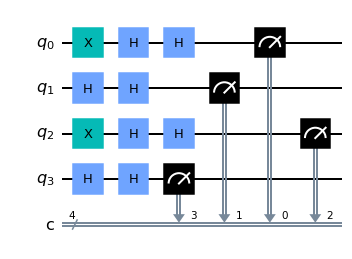

In [31]:
dj_left5.x(2)
dj_left5.x(0)
dj_left5 += dj_left0
dj_left5.draw()

/tmp/ipykernel_1505/2426855407.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left6 += dj_left0


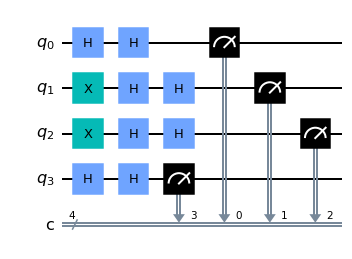

In [32]:
dj_left6.x(2)
dj_left6.x(1)
dj_left6 += dj_left0
dj_left6.draw()

/tmp/ipykernel_1505/778788731.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left7 += dj_left0


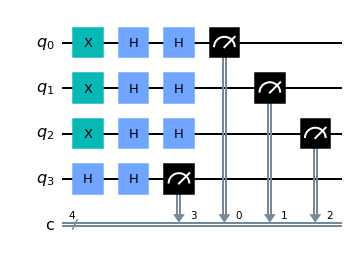

In [33]:
dj_left7.x(2)
dj_left7.x(1)
dj_left7.x(0)
dj_left7 += dj_left0
dj_left7.draw()

/tmp/ipykernel_1505/989489376.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left8 += dj_left0


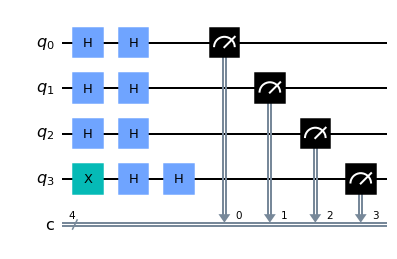

In [34]:
dj_left8.x(3)
dj_left8 += dj_left0
dj_left8.draw()

/tmp/ipykernel_1505/209537080.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left9 += dj_left0


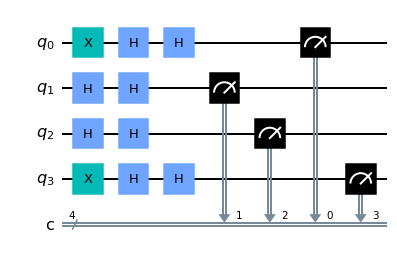

In [35]:
dj_left9.x(3)
dj_left9.x(0)
dj_left9 += dj_left0
dj_left9.draw()

/tmp/ipykernel_1505/2470987004.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left10 += dj_left0


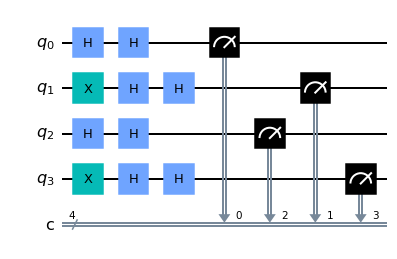

In [36]:
dj_left10.x(3)
dj_left10.x(1)
dj_left10 += dj_left0
dj_left10.draw()

/tmp/ipykernel_1505/4258748235.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left11 += dj_left0


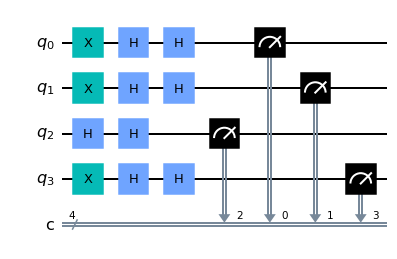

In [37]:
dj_left11.x(3)
dj_left11.x(1)
dj_left11.x(0)
dj_left11 += dj_left0
dj_left11.draw()

/tmp/ipykernel_1505/4044102656.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left12 += dj_left0


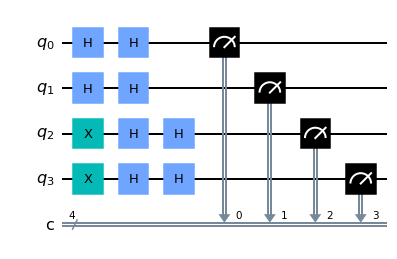

In [38]:
dj_left12.x(3)
dj_left12.x(2)
dj_left12 += dj_left0
dj_left12.draw()

/tmp/ipykernel_1505/1494147891.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left13 += dj_left0


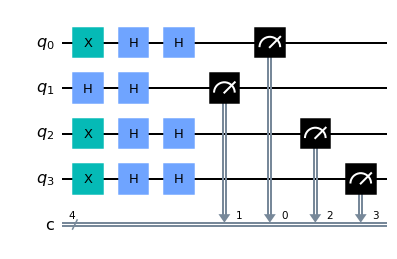

In [39]:
dj_left13.x(3)
dj_left13.x(2)
dj_left13.x(0)
dj_left13 += dj_left0
dj_left13.draw()

/tmp/ipykernel_1505/3820195286.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left14 += dj_left0


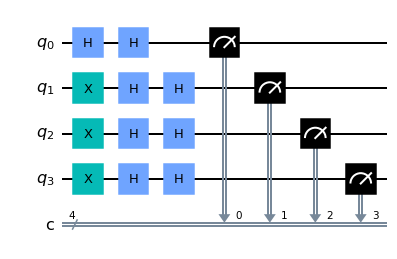

In [40]:
dj_left14.x(3)
dj_left14.x(2)
dj_left14.x(1)
dj_left14 += dj_left0
dj_left14.draw()

/tmp/ipykernel_1505/1035582658.py:5: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left15 += dj_left0


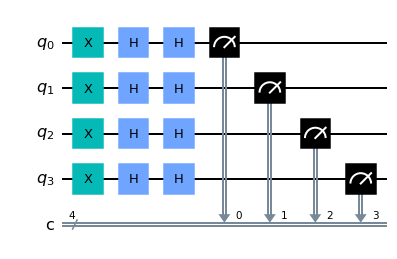

In [41]:
dj_left15.x(3)
dj_left15.x(2)
dj_left15.x(1)
dj_left15.x(0)
dj_left15 += dj_left0
dj_left15.draw()

In [42]:
meas_calibs = [dj_left0, dj_left1, dj_left2, dj_left3, dj_left4, dj_left5, dj_left6, dj_left7, dj_left8, dj_left9, dj_left10, dj_left11, dj_left12, dj_left13, dj_left14, dj_left15]
print(len(meas_calibs))

16


In [43]:
# t_qc = transpile(meas_calibs, aer_sim)
# qobj = assemble(t_qc, shots=10000)
# results = aer_sim.run(qobj, shots=10000).result()
# result_counts = results.get_counts()
# print(result_counts)

In [44]:
t_qc = transpile(meas_calibs, real_backend)
qobj = assemble(t_qc, shots=10000)
real_results = real_backend.run(qobj, shots=10000).result()

/tmp/ipykernel_1505/1499486007.py:3: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  real_results = real_backend.run(qobj, shots=10000).result()


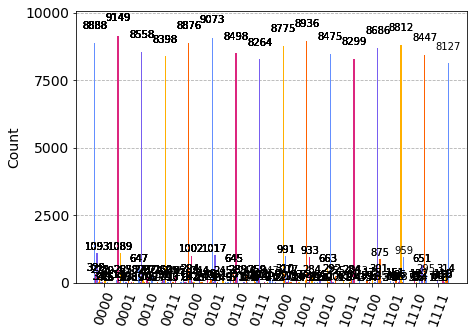

In [45]:
real_counts = real_results.get_counts()
plot_histogram(real_counts)

In [46]:
ls = []
for qc in meas_calibs:
     counts = real_results.get_counts(qc)
     this_array = np.array([counts.get('0000') or 0, counts.get('0001') or 0, counts.get('0010') or 0, counts.get('0011') or 0 , counts.get('0100') or 0, counts.get('0101') or 0, counts.get('0110') or 0, counts.get('0111') or 0, counts.get('1000') or 0, counts.get('1001') or 0, counts.get('1010') or 0, counts.get('1011') or 0, counts.get('1100') or 0, counts.get('1101') or 0, counts.get('1110') or 0, counts.get('1111') or 0])
     this_array = this_array/10000
     ls.append(this_array)
     print(len(this_array))
     print(this_array)
     
array = np.array(ls)
# print(array)
array_t = np.transpose(array)
print(array_t)

16
[8.888e-01 1.130e-02 6.470e-02 7.000e-04 1.700e-02 0.000e+00 9.000e-04
 0.000e+00 1.500e-02 1.000e-04 1.200e-03 0.000e+00 3.000e-04 0.000e+00
 0.000e+00 0.000e+00]
16
[3.290e-02 9.149e-01 9.000e-04 2.600e-02 6.000e-04 1.400e-02 0.000e+00
 4.000e-04 1.000e-04 9.700e-03 1.000e-04 1.000e-04 0.000e+00 3.000e-04
 0.000e+00 0.000e+00]
16
[1.093e-01 9.000e-04 8.558e-01 9.100e-03 1.900e-03 0.000e+00 1.350e-02
 3.000e-04 7.000e-04 0.000e+00 8.400e-03 1.000e-04 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
16
[3.400e-03 1.089e-01 2.710e-02 8.398e-01 0.000e+00 1.300e-03 5.000e-04
 1.110e-02 0.000e+00 8.000e-04 5.000e-04 6.500e-03 0.000e+00 0.000e+00
 0.000e+00 1.000e-04]
16
[2.720e-02 2.000e-04 2.000e-03 0.000e+00 8.876e-01 1.090e-02 6.450e-02
 8.000e-04 2.000e-04 0.000e+00 2.000e-04 0.000e+00 5.900e-03 0.000e+00
 5.000e-04 0.000e+00]
16
[7.000e-04 2.650e-02 0.000e+00 1.100e-03 2.940e-02 9.073e-01 7.000e-04
 2.590e-02 0.000e+00 4.000e-04 0.000e+00 0.000e+00 3.000e-04 7.600e-03
 0.000e+00 1.000e-04

In [47]:
array_to_latex(array)

<IPython.core.display.Latex object>

In [48]:
import scipy.linalg as la
array_inv = la.inv(array_t)
array_to_latex(array_inv)

<IPython.core.display.Latex object>

In [49]:
counts = realqc_results.get_counts()

In [50]:
result_array = np.array([counts.get('0000') or 0, counts.get('0001') or 0, counts.get('0010') or 0, counts.get('0011') or 0 , counts.get('0100') or 0, counts.get('0101') or 0, counts.get('0110') or 0, counts.get('0111') or 0, counts.get('1000') or 0, counts.get('1001') or 0, counts.get('1010') or 0, counts.get('1011') or 0, counts.get('1100') or 0, counts.get('1101') or 0, counts.get('1110') or 0, counts.get('1111') or 0])
result_array = result_array/1000

In [51]:
result_array

array([0.951, 0.01 , 0.011, 0.   , 0.012, 0.   , 0.   , 0.   , 0.016,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [52]:
mitigated = np.dot(array_inv, result_array)

In [59]:
mitigated

array([ 1.07872944e+00, -2.31486500e-03, -6.86668144e-02, -8.43403762e-05,
       -7.04179449e-03,  1.17337987e-04,  4.81784760e-04,  2.43441056e-05,
       -4.09247975e-05, -9.65905923e-05, -8.42819384e-04,  2.07838091e-05,
       -3.26665217e-04,  4.59930945e-06,  3.73163375e-05, -7.94722393e-07])

In [54]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
normal = NormalizeData(mitigated)

In [60]:
normal

array([1.        , 0.05782828, 0.        , 0.05977227, 0.05370858,
       0.05994804, 0.06026567, 0.05986699, 0.0598101 , 0.05976159,
       0.05911122, 0.05986389, 0.05956107, 0.05984978, 0.05987829,
       0.05984508])

In [56]:
def Normalize(arr):
    return arr/sum(arr)

In [57]:
new_normal = Normalize(mitigated)

In [61]:
new_normal

array([ 1.07872944e+00, -2.31486500e-03, -6.86668144e-02, -8.43403762e-05,
       -7.04179449e-03,  1.17337987e-04,  4.81784760e-04,  2.43441056e-05,
       -4.09247975e-05, -9.65905923e-05, -8.42819384e-04,  2.07838091e-05,
       -3.26665217e-04,  4.59930945e-06,  3.73163375e-05, -7.94722393e-07])